# Thư viện

In [3]:
import os
import rando
import pandas as pd
import r
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

# I.  Dataset

In [1]:
def count_images_per_person(face_data_dir):
    people_image_count = {}
    for person in os.listdir(face_data_dir):
        person_path = os.path.join(face_data_dir, person)
        
        if os.path.isdir(person_path):
            image_count = len([
                f for f in os.listdir(person_path) 
                if os.path.isfile(os.path.join(person_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            people_image_count[person] = image_count

    return people_image_count


face_data_path = '/kaggle/input/face-recognition-dataset/Face Data/Face Dataset'
image_counts = count_images_per_person(face_data_path)
df_folder = pd.DataFrame(list(image_counts.items()), columns=['Person', 'Image_Count'])
df_folder['Person_ID'] = df_folder['Person'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df_folder = df_folder.sort_values(by='Person_ID').reset_index(drop=True)




In [2]:
df_folder

,Person,Image_Count,Person_ID
0,0,4,0
1,1,2,1
2,2,2,2
3,3,4,3
4,4,4,4
...,...,...,...
1675,1675,4,1675
1676,1676,9,1676
1677,1677,3,1677
1678,1678,6,1678


In [3]:
min_count = df_folder['Image_Count'].min()
max_count = df_folder['Image_Count'].max()
mean_count = df_folder['Image_Count'].mean()

print(f'Số ảnh ít nhất (min): {min_count}')
print(f'Số ảnh nhiều nhất (max): {max_count}')
print(f'Số ảnh trung bình (mean): {mean_count:.2f}')


Số ảnh ít nhất (min): 2
Số ảnh nhiều nhất (max): 50
Số ảnh trung bình (mean): 4.88


## I.1. Một số hình trong Folder

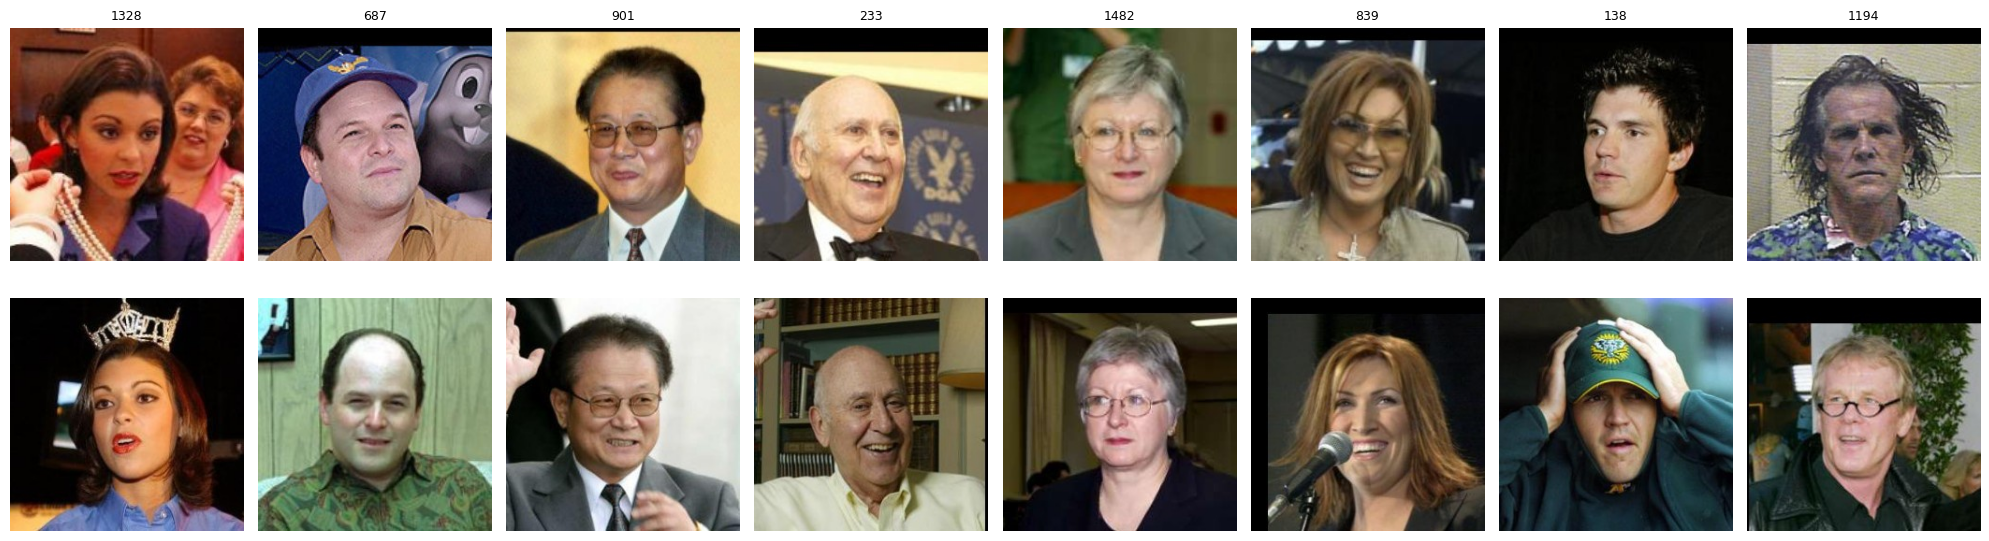

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def get_two_images_per_folder(base_dir, num_samples=10):
    folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    selected_folders = random.sample(folder_names, min(num_samples, len(folder_names)))

    top_images = []
    bottom_images = []
    labels = []

    for folder in selected_folders:
        folder_path = os.path.join(base_dir, folder)
        image_files = [f for f in os.listdir(folder_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(image_files) < 2:
            continue  # bỏ qua nếu không đủ 2 ảnh

        selected_imgs = random.sample(image_files, 2)
        top_images.append(os.path.join(folder_path, selected_imgs[0]))
        bottom_images.append(os.path.join(folder_path, selected_imgs[1]))
        labels.append(folder)

    return top_images, bottom_images, labels

def display_image_grid(top_images, bottom_images, labels):
    total = len(labels)
    plt.figure(figsize=(total * 2.5, 6))

    # Hàng trên
    for i, (img_path, label) in enumerate(zip(top_images, labels)):
        try:
            img = Image.open(img_path)
            plt.subplot(2, total, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label, fontsize=9)
        except Exception as e:
            print(f"Lỗi ảnh trên: {img_path} ({e})")

    # Hàng dưới
    for i, img_path in enumerate(bottom_images):
        try:
            img = Image.open(img_path)
            plt.subplot(2, total, total + i + 1)
            plt.imshow(img)
            plt.axis('off')
        except Exception as e:
            print(f"Lỗi ảnh dưới: {img_path} ({e})")

    plt.tight_layout()
    plt.show()


face_data_path = '/kaggle/input/face-recognition-dataset/Face Data/Face Dataset'
top_imgs, bottom_imgs, folder_labels = get_two_images_per_folder(face_data_path, num_samples=8)
display_image_grid(top_imgs, bottom_imgs, folder_labels)


# II. Processing Data

## II.1 Kiểm tra ảnh bị lỗi

In [5]:
import os
from PIL import Image
from collections import defaultdict

def check_corrupt_images(face_data_dir):
    error_report = defaultdict(list)

    for person in os.listdir(face_data_dir):
        person_path = os.path.join(face_data_dir, person)
        
        if os.path.isdir(person_path):
            for filename in os.listdir(person_path):
                file_path = os.path.join(person_path, filename)
                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # chỉ kiểm tra, không cần load ảnh đầy đủ
                    except Exception as e:
                        error_report[person].append(filename)

    return error_report

# Ví dụ sử dụng:
face_data_path = '/kaggle/input/face-recognition-dataset/Face Data/Face Dataset'
corrupt_images = check_corrupt_images(face_data_path)

# In kết quả:
for person, files in corrupt_images.items():
    print(f'{person}: {len(files)} ảnh lỗi')
    for f in files:
        print(f'  - {f}')


## II.2 Tăng cường dữ liệu mỗi thư mục ít nhất 10 ảnh 

In [ ]:
import os
import shutil
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
from collections import defaultdict, Counter
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_spli

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
class FaceDatasetAugmentor:
    def __init__(self, input_dir, output_dir, min_images=10):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.min_images = min_images

    def _ensure_dir(self, path):
        os.makedirs(path, exist_ok=True)

    def _get_image_files(self, path):
        return [
            f for f in os.listdir(path)
            if os.path.isfile(os.path.join(path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def _augment_image(self, img):
        ops = [
            lambda x: x.rotate(random.randint(-20, 20)),
            lambda x: ImageOps.mirror(x),
            lambda x: ImageOps.flip(x),
            lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.7, 1.3)),
            lambda x: ImageEnhance.Contrast(x).enhance(random.uniform(0.8, 1.2)),
        ]
        return random.choice(ops)(img)

    def _copy_original_images(self, src_folder, dst_folder, image_files):
        for img_name in image_files:
            src_path = os.path.join(src_folder, img_name)
            dst_path = os.path.join(dst_folder, img_name)
            if os.path.abspath(src_path) != os.path.abspath(dst_path):
                shutil.copy2(src_path, dst_path)

    def _augment_images(self, src_folder, dst_folder, image_files, num_to_generate):
        for i in range(num_to_generate):
            img_name = random.choice(image_files)
            img_path = os.path.join(src_folder, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    aug_img = self._augment_image(img)
                    aug_name = f'aug_{i}_{img_name}'
                    aug_img.save(os.path.join(dst_folder, aug_name))
            except Exception as e:
                print(f"Lỗi khi tăng cường ảnh {img_name} trong {os.path.basename(src_folder)}: {e}")

    def run(self):
        folder_names = [f for f in os.listdir(self.input_dir) if os.path.isdir(os.path.join(self.input_dir, f))]

        for folder in tqdm(folder_names, desc="Tăng cường dữ liệu"):
            src_folder = os.path.join(self.input_dir, folder)
            dst_folder = os.path.join(self.output_dir, folder)
            self._ensure_dir(dst_folder)

            image_files = self._get_image_files(src_folder)
            self._copy_original_images(src_folder, dst_folder, image_files)

            if len(image_files) < self.min_images:
                num_to_generate = self.min_images - len(image_files)
                self._augment_images(src_folder, dst_folder, image_files, num_to_generate

##  II.3 Tạo Dataset và DataLoader

In [ ]:

class SiameseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, return_path=False):
        self.transform = transform
        self.return_path = return_path
        self.label_to_paths = defaultdict(list)

        for path, label in zip(image_paths, labels):
            self.label_to_paths[label].append(path)

        self.positive_pairs = []
        self.negative_pairs = []

        # Positive pairs
        for label, paths in self.label_to_paths.items():
            if len(paths) < 2:
                continue
            for i in range(len(paths)):
                for j in range(i + 1, len(paths)):
                    self.positive_pairs.append((paths[i], paths[j], 1.0, label, label))

        # Negative pairs
        labels_list = list(self.label_to_paths.keys())
        num_pos = len(self.positive_pairs)
        while len(self.negative_pairs) < num_pos:
            label1, label2 = random.sample(labels_list, 2)
            path1 = random.choice(self.label_to_paths[label1])
            path2 = random.choice(self.label_to_paths[label2])
            self.negative_pairs.append((path1, path2, 0.0, label1, label2))

        self.pairs = [p for pair in zip(self.positive_pairs, self.negative_pairs) for p in pair]
        random.shuffle(self.pairs)

    def __getitem__(self, index):
        img1_path, img2_path, label, label1, label2 = self.pairs[index]
        img1 = self.transform(Image.open(img1_path).convert("RGB"))
        img2 = self.transform(Image.open(img2_path).convert("RGB"))

        if self.return_path:
            return img1, img2, torch.tensor([label], dtype=torch.float32), label1, label2, img1_path
        else:
            return img1, img2, torch.tensor([label], dtype=torch.float32), label1, label2

    def __len__(self):
        return len(self.pairs)

In [3]:

dataset_path = "/kaggle/input/face-recognition-dataset/Face Data/Face Dataset"

# Step 1: Load toàn bộ dữ liệu
full_dataset = datasets.ImageFolder(root=dataset_path)
image_paths = [x[0] for x in full_dataset.imgs]
labels = [x[1] for x in full_dataset.imgs]

# Step 2: Giữ lại label có ít nhất 4 ảnh
label_counts = Counter(labels)
valid_labels = {label for label, count in label_counts.items() if count >= 4}
filtered_image_paths = [p for p, l in zip(image_paths, labels) if l in valid_labels]
filtered_labels = [l for p, l in zip(image_paths, labels) if l in valid_labels]

# Step 3: Tách train/test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    filtered_image_paths, filtered_labels, test_size=0.2, stratify=filtered_labels, random_state=42
)

# Step 4: Copy ảnh train gốc sang thư mục mới
raw_train_dir = "/kaggle/working/train_raw"
for path, label in zip(train_paths, train_labels):
    label_dir = os.path.join(raw_train_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)
    shutil.copy2(path, os.path.join(label_dir, os.path.basename(path)))

# Step 5: Tăng cường dữ liệu ảnh train
augmented_train_dir = "/kaggle/working/train_augmented"
augmentor = FaceDatasetAugmentor(input_dir=raw_train_dir, output_dir=augmented_train_dir, min_images=10)
augmentor.run()

# Step 6: Load lại tập dữ liệu đã được augment
train_dataset_imgfolder = datasets.ImageFolder(root=augmented_train_dir)
train_image_paths = [x[0] for x in train_dataset_imgfolder.imgs]
train_labels = [x[1] for x in train_dataset_imgfolder.imgs]

# Step 7: Tạo transform và dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = SiameseDataset(train_image_paths, train_labels, transform=transform)
test_dataset = SiameseDataset(test_paths, test_labels, transform=transform, return_path=True)

# Step 8: Tạo DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)


Tăng cường dữ liệu: 100%|██████████| 610/610 [00:04<00:00, 148.47it/s]


## II.4 Xem một số ảnh trong Train Data Loader

In [5]:
batch = next(iter(train_loader))
img1, img2, labels, label1s, label2s = batch
num_positive = (labels == 1.0).sum().item()
num_negative = (labels == 0.0).sum().item()
print(f"Positive: {num_positive}, Negative: {num_negative}")


Positive: 72, Negative: 56


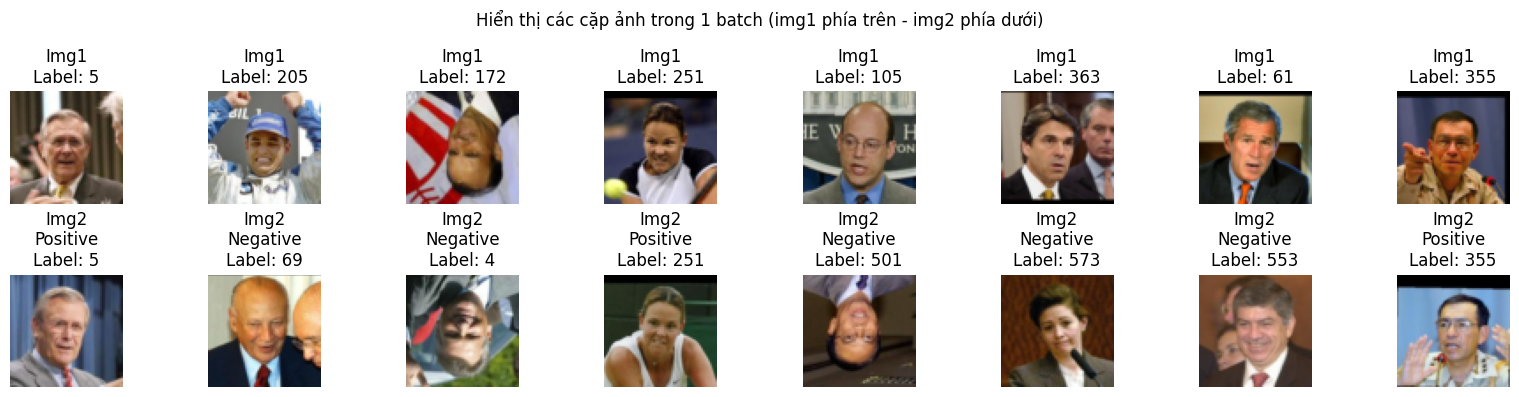

In [6]:
import matplotlib.pyplot as plt

img1_batch, img2_batch, labels, label1s, label2s = next(iter(train_loader))

num_pairs_to_show = min(8, len(labels))
plt.figure(figsize=(16, 4))
for i in range(num_pairs_to_show):
    # Hiển thị img1
    plt.subplot(2, num_pairs_to_show, i + 1)
    plt.imshow(img1_batch[i].permute(1, 2, 0))  # (C,H,W) -> (H,W,C)
    plt.title(f"Img1\nLabel: {label1s[i]}")
    plt.axis('off')

    # Hiển thị img2
    plt.subplot(2, num_pairs_to_show, num_pairs_to_show + i + 1)
    plt.imshow(img2_batch[i].permute(1, 2, 0))
    pair_type = "Positive" if labels[i].item() == 1.0 else "Negative"
    plt.title(f"Img2\n{pair_type}\nLabel: {label2s[i]}")
    plt.axis('off')

plt.suptitle("Hiển thị các cặp ảnh trong 1 batch (img1 phía trên - img2 phía dưới)")
plt.tight_layout()
plt.show()


# III. Model CLIP

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QuickGELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model=768, n_head=8):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_head, batch_first=True)
        self.ln_2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 3072),
            QuickGELU(),
            nn.Linear(3072, d_model)
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x), self.ln_1(x), self.ln_1(x))[0]
        x = x + self.mlp(self.ln_2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, image_size=64, patch_size=16, d_model=768, depth=12, n_head=8):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d_model, kernel_size=patch_size, stride=patch_size, bias=False)
        num_patches = (image_size // patch_size) ** 2

        # Thêm cls token và vị trí embedding
        self.class_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))

        self.ln_pre = nn.LayerNorm(d_model)
        self.transformer = nn.Sequential(*[
            ResidualAttentionBlock(d_model, n_head) for _ in range(depth)
        ])
        self.ln_post = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.conv1(x)  # [B, C, H, W] -> [B, d_model, h, w]
        x = x.flatten(2).transpose(1, 2)  # [B, d_model, N] -> [B, N, d_model]

        cls_token = self.class_embedding.expand(x.size(0), -1, -1)  # [B, 1, d_model]
        x = torch.cat([cls_token, x], dim=1)  # [B, N+1, d_model]

        x = x + self.positional_embedding[:, :x.size(1), :]
        x = self.ln_pre(x)
        x = self.transformer(x)
        return self.ln_post(x[:, 0])  # Trả về embedding của [CLS] token


class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer()

    def forward(self, x):
        return self.vit(x)


class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        return self.embedding_net(x1), self.embedding_net(x2)


def contrastive_loss(output1, output2, label, margin=0.5):
    distances = F.pairwise_distance(output1, output2)
    label = label.view(-1).float().to(distances.device)

    loss = label * distances.pow(2) + (1 - label) * F.relu(margin - distances).pow(2)
    return loss.mean()


# Huấn luyện

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_net = EmbeddingNet().to(device)
model = SiameseNet(embedding_net).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
from tqdm import tqdm

batch_losses = []
epoch_losses = []

for epoch in range(3):
    model.train()
    total_loss = 0
    epoch_batch_losses = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for x1, x2, y, _, _ in loop:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        out1, out2 = model(x1, x2)
        loss = contrastive_loss(out1, out2, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        total_loss += batch_loss
        epoch_batch_losses.append(batch_loss)
        batch_losses.append(batch_loss)

        loop.set_postfix(loss=batch_loss)

    avg_epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_epoch_loss:.4f}")




Epoch 1, Avg Loss: 0.0601


Epoch 2, Avg Loss: 0.0468


Epoch 3, Avg Loss: 0.0433


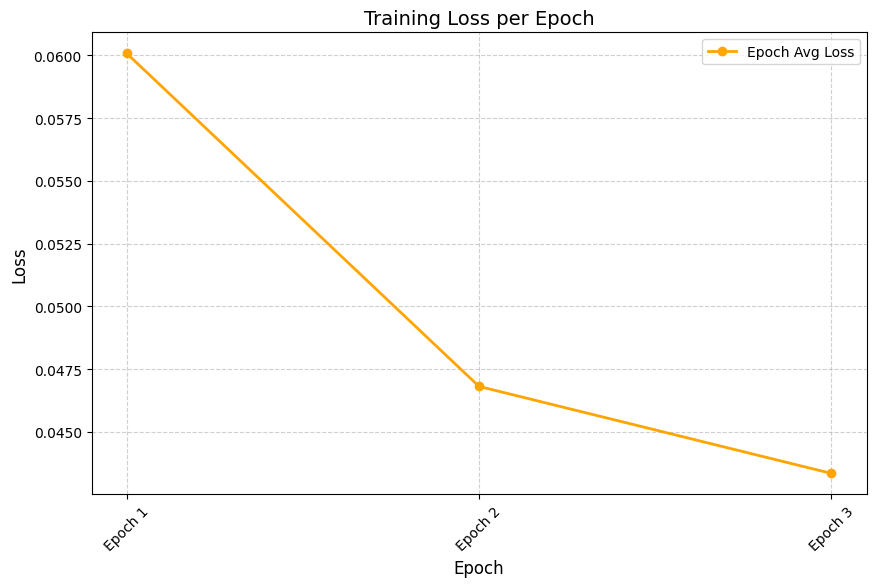

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, marker='o', color='orange', linewidth=2, markersize=6, label="Epoch Avg Loss")
plt.title("Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(
    ticks=range(len(epoch_losses)),
    labels=[f"Epoch {i+1}" for i in range(len(epoch_losses))],
    rotation=45,
    fontsize=10
)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# IV. Test

In [20]:
import matplotlib.pyplot as plt

def show_images(img1, img2, label1, label2, y_true, y_pred):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img1.permute(1, 2, 0).cpu())
    axes[0].set_title(f"Ảnh 1\nLabel: {label1}")
    axes[0].axis("off")

    axes[1].imshow(img2.permute(1, 2, 0).cpu())
    axes[1].set_title(f"Ảnh 2\nLabel: {label2}")
    axes[1].axis("off")

    plt.suptitle(f"Thật: {int(y_true)} | Dự đoán: {int(y_pred)}")
    plt.tight_layout()
    plt.show()


## IV.1. Tập Train 

In [26]:
from torch.nn import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

correct = 0
total = 0
threshold = 0.2  # 👈 Tùy chỉnh ngưỡng nếu cần

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for i, (x1, x2, y_true, label1, label2, *rest) in enumerate(train_loader):
        x1, x2 = x1.to(device), x2.to(device)
        y_true = y_true.view(-1).to(device)

        # Forward
        out1, out2 = model(x1, x2)
        dist = F.pairwise_distance(out1, out2)

        # Dự đoán: nếu khoảng cách nhỏ hơn ngưỡng → cùng người
        y_pred = (dist < threshold).float().view(-1)

        # Tính số lượng đúng
        correct += (y_pred == y_true).sum().item()
        total += y_true.size(0)

        # Lưu để tính metric sau này
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y_true.cpu().numpy())

        

# 🎯 Accuracy
accuracy = correct / total

# 🧮 Các metric khác
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)



🎯 Accuracy      : 72.92%
📌 Precision     : 83.56%
📌 Recall        : 57.06%
📌 F1-score      : 67.81%


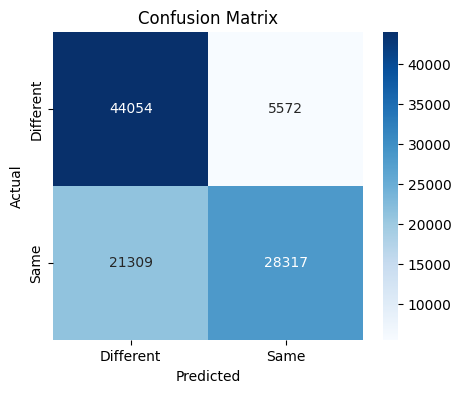

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"\n🎯 Accuracy      : {accuracy * 100:.2f}%")
print(f"📌 Precision     : {precision * 100:.2f}%")
print(f"📌 Recall        : {recall * 100:.2f}%")
print(f"📌 F1-score      : {f1 * 100:.2f}%")
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## IV.2 Tập Test 


📦 Batch 1
✅ Nhãn thực tế: [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
🔍 Dự đoán      : [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
🧬 Label ảnh 1  : tensor([ 153,  946,  458,  373,  918, 1179,  655, 1300,  156, 1297,  212,   70,
        1161, 1596, 1460, 1161,  302, 1091, 1205, 1379,    6,  752, 1161,   11,
         368, 1357,  992,  521,  654,  992, 1237,  822])
🧬 Label ảnh 2  : tensor([ 927,  946, 1300,  373,  918, 1179,  655,  287,  123, 1297,  212, 1547,
        1161,  244,  112, 1161,  302, 1191, 1205, 1379,  914, 1669, 1161,   11,
         870, 1357, 1321,  521,  523,  992, 1237,  822])

🔢 Cặp ảnh 1 - Khoảng cách: 0.6304


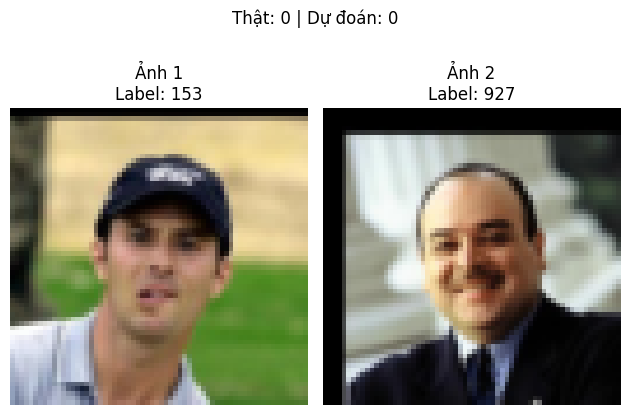


🔢 Cặp ảnh 2 - Khoảng cách: 0.2719


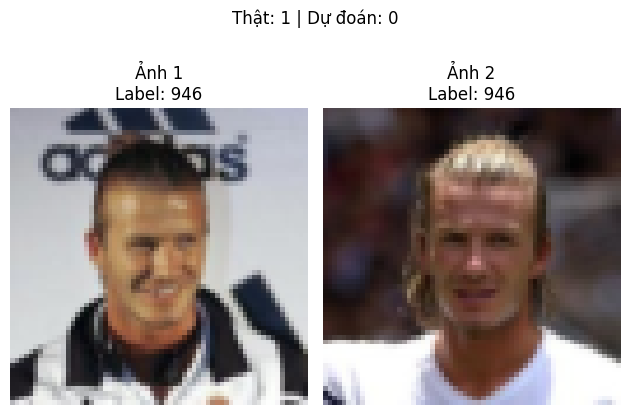


🔢 Cặp ảnh 3 - Khoảng cách: 0.3167


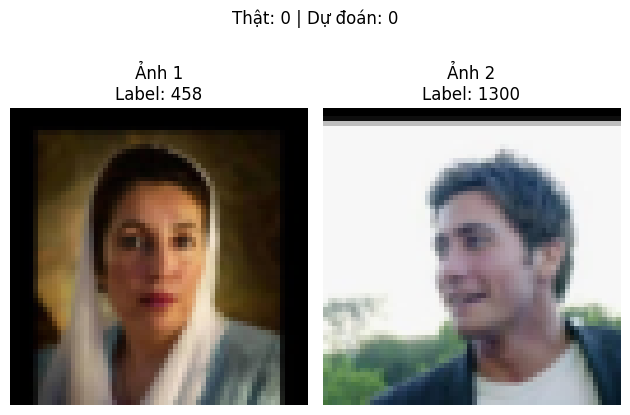


🔢 Cặp ảnh 4 - Khoảng cách: 0.0605


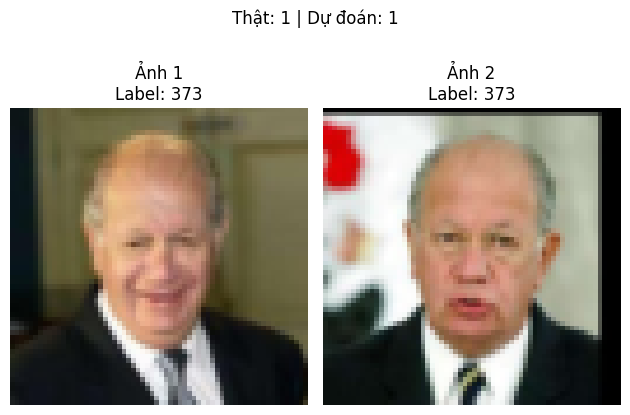


🔢 Cặp ảnh 5 - Khoảng cách: 0.2493


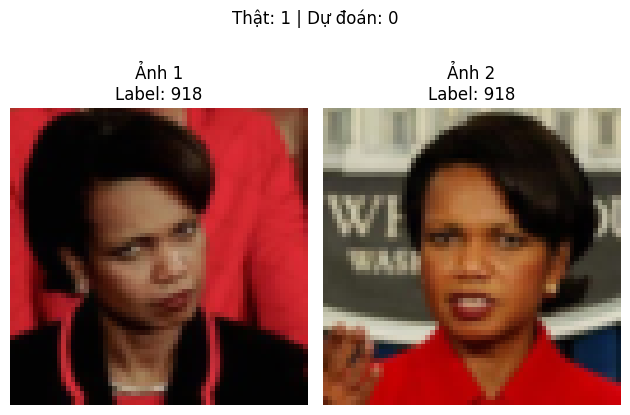


🔢 Cặp ảnh 6 - Khoảng cách: 0.1754


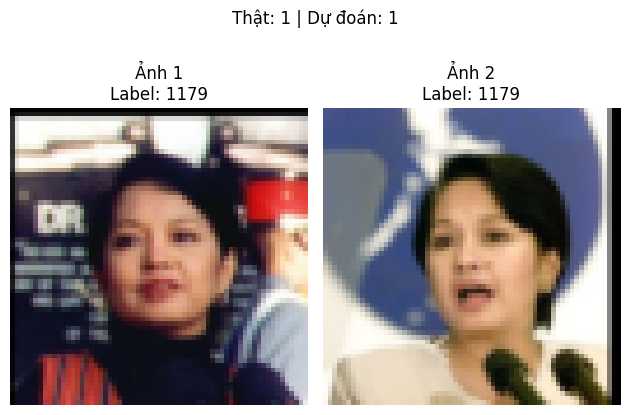


🔢 Cặp ảnh 7 - Khoảng cách: 0.1378


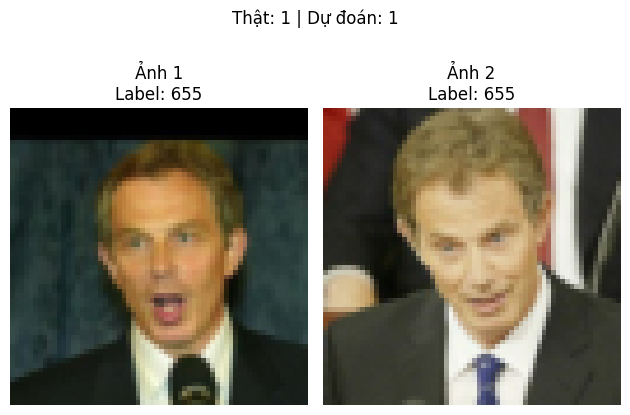


🔢 Cặp ảnh 8 - Khoảng cách: 0.3401


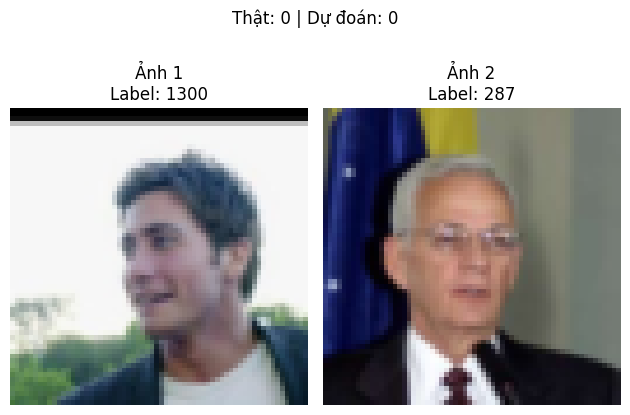


🔢 Cặp ảnh 9 - Khoảng cách: 0.2880


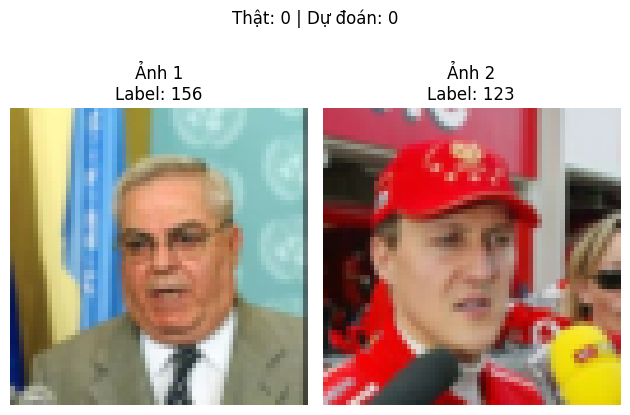


🔢 Cặp ảnh 10 - Khoảng cách: 0.1183


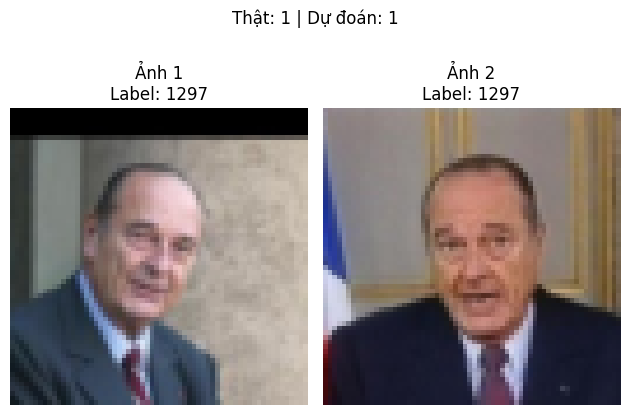


🔢 Cặp ảnh 11 - Khoảng cách: 0.1859


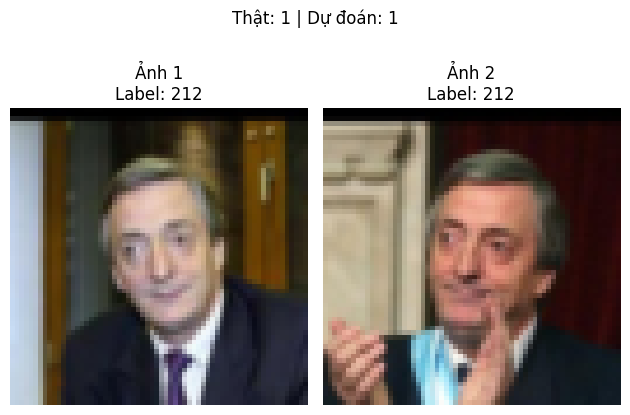


🔢 Cặp ảnh 12 - Khoảng cách: 0.3560


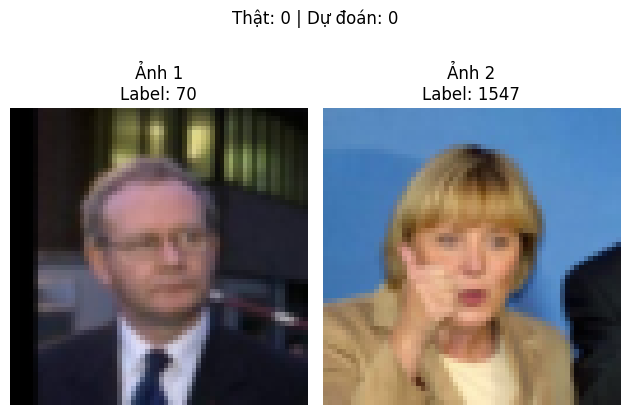


🔢 Cặp ảnh 13 - Khoảng cách: 0.1370


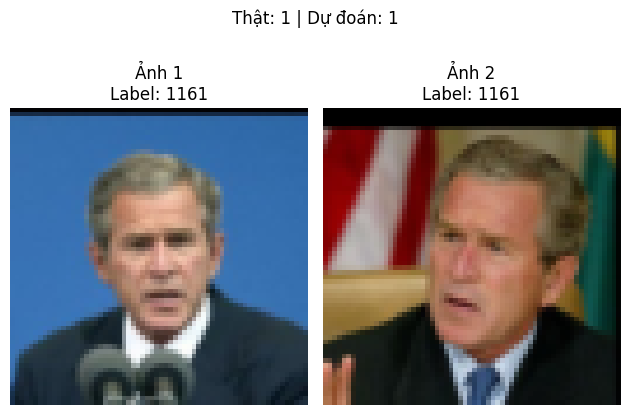


🔢 Cặp ảnh 14 - Khoảng cách: 0.6734


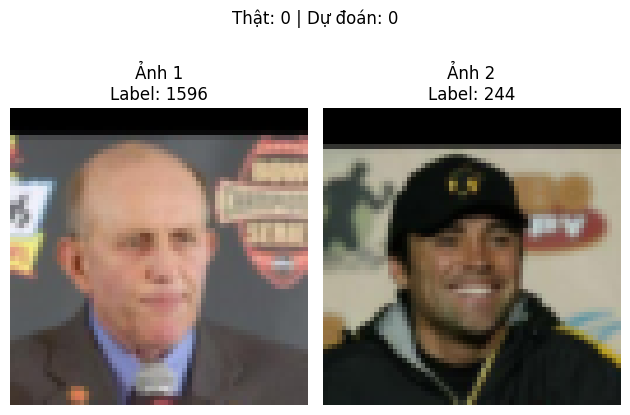


🔢 Cặp ảnh 15 - Khoảng cách: 0.2944


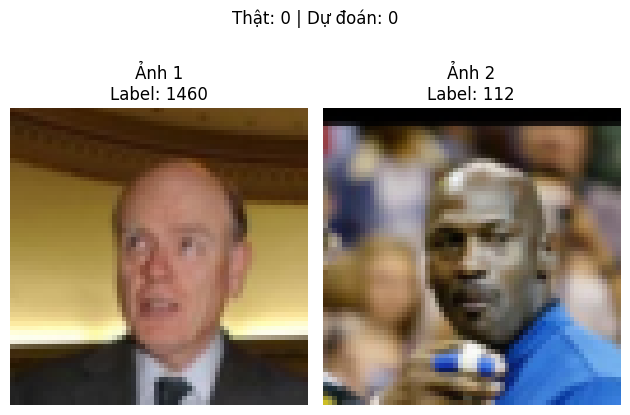


🔢 Cặp ảnh 16 - Khoảng cách: 0.1989


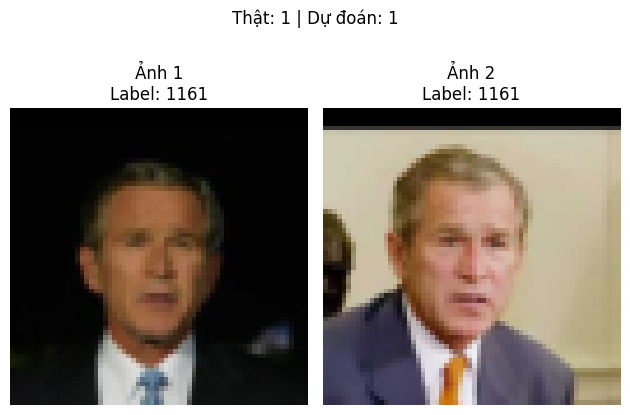


🔢 Cặp ảnh 17 - Khoảng cách: 0.2632


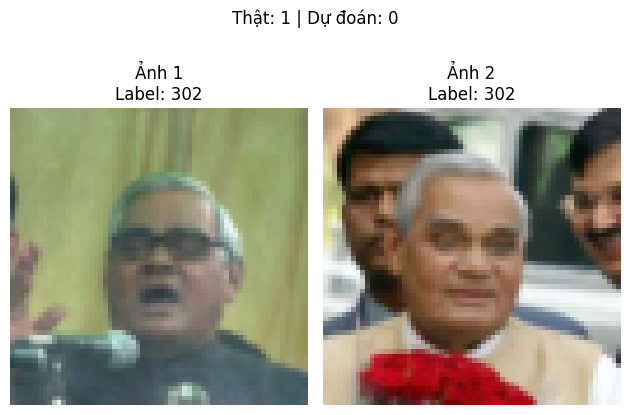


🔢 Cặp ảnh 18 - Khoảng cách: 0.3309


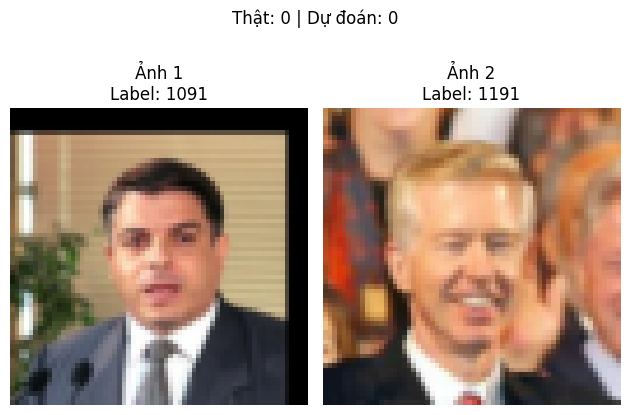


🔢 Cặp ảnh 19 - Khoảng cách: 0.3259


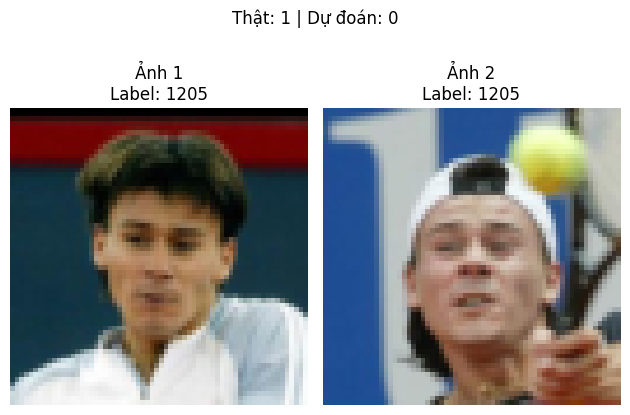


🔢 Cặp ảnh 20 - Khoảng cách: 0.1853


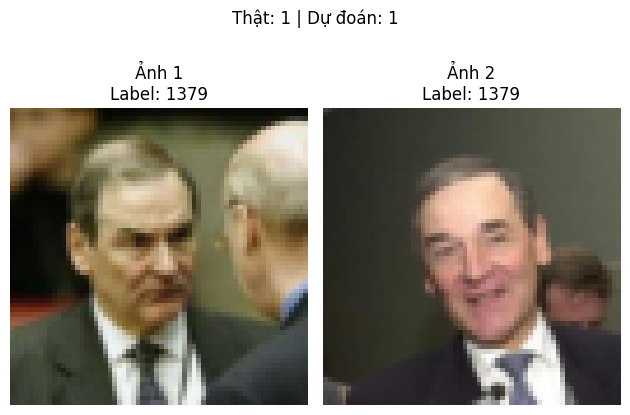


🔢 Cặp ảnh 21 - Khoảng cách: 0.5599


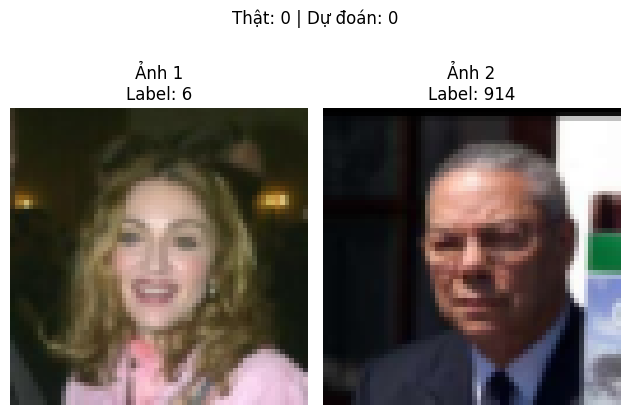


🔢 Cặp ảnh 22 - Khoảng cách: 0.3965


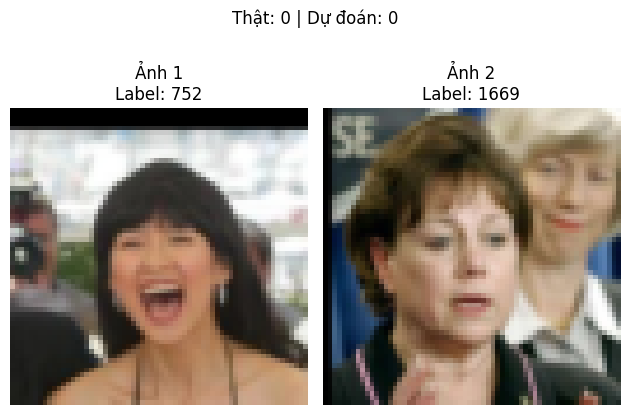


🔢 Cặp ảnh 23 - Khoảng cách: 0.1843


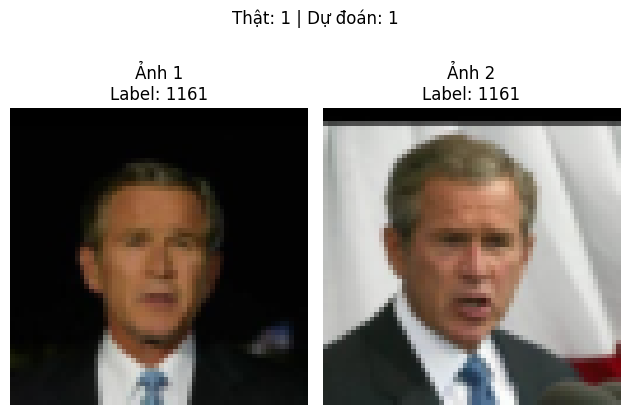


🔢 Cặp ảnh 24 - Khoảng cách: 0.1154


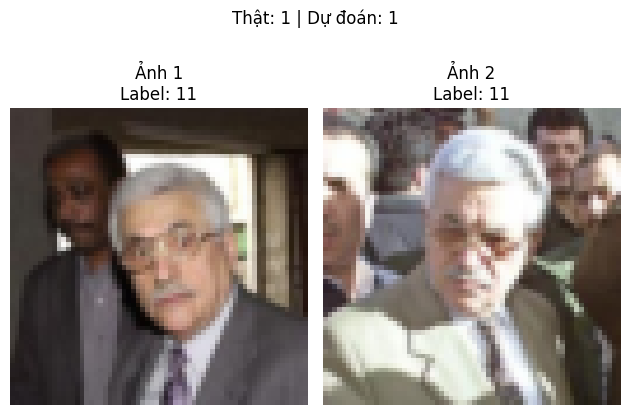


🔢 Cặp ảnh 25 - Khoảng cách: 0.3428


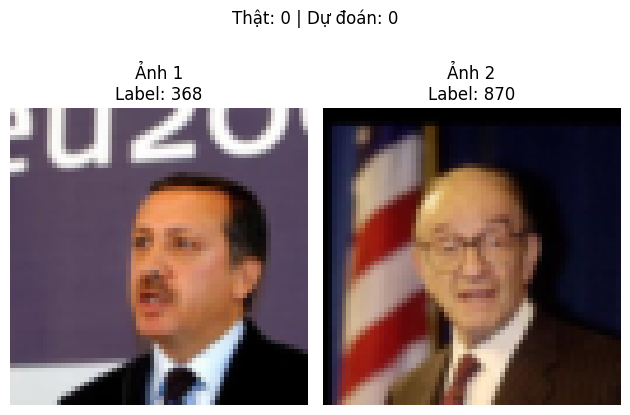


🔢 Cặp ảnh 26 - Khoảng cách: 0.1810


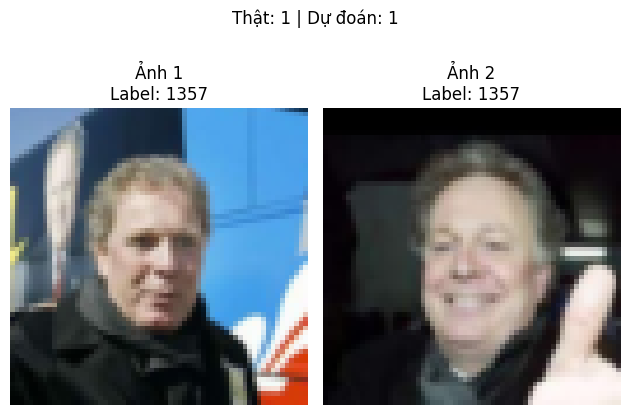


🔢 Cặp ảnh 27 - Khoảng cách: 0.1999


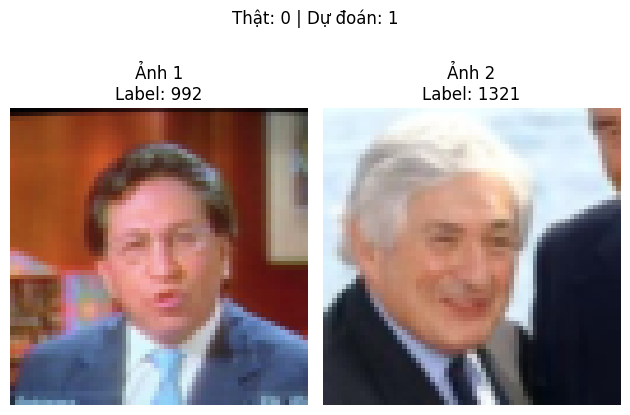


🔢 Cặp ảnh 28 - Khoảng cách: 0.1941


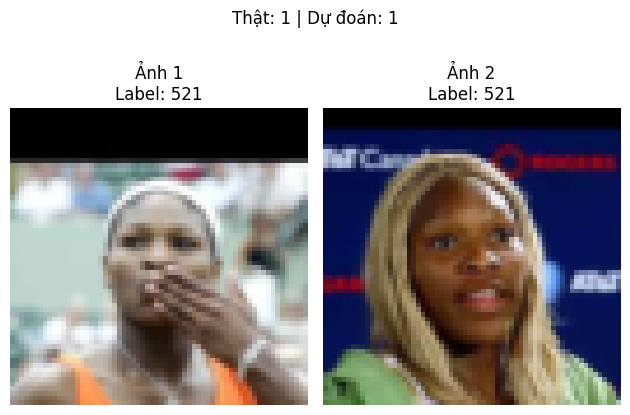


🔢 Cặp ảnh 29 - Khoảng cách: 0.1829


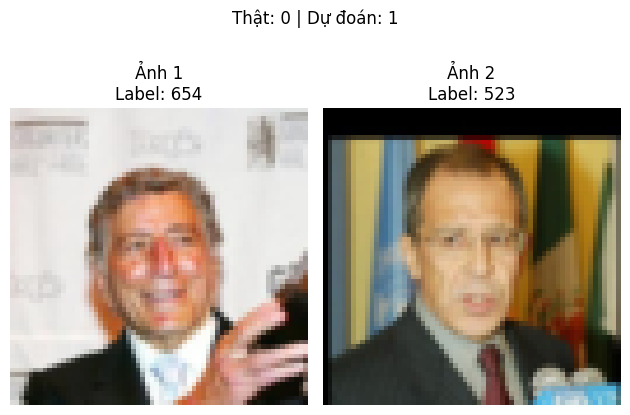


🔢 Cặp ảnh 30 - Khoảng cách: 0.1458


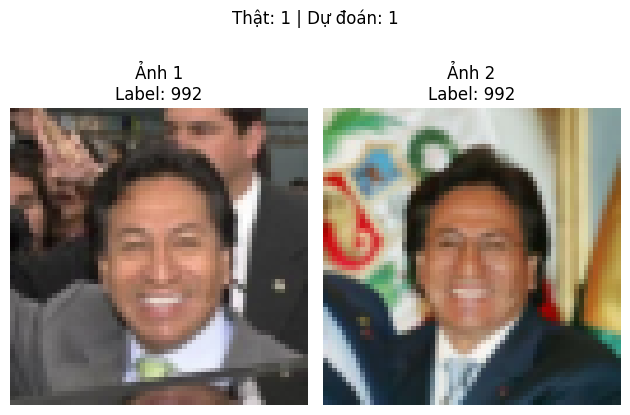


🔢 Cặp ảnh 31 - Khoảng cách: 0.1554


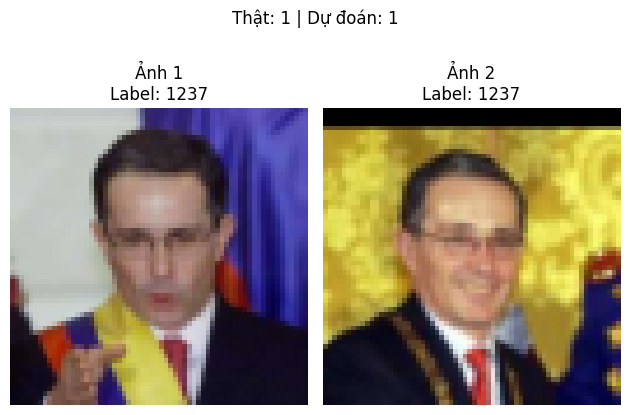


🔢 Cặp ảnh 32 - Khoảng cách: 0.3737


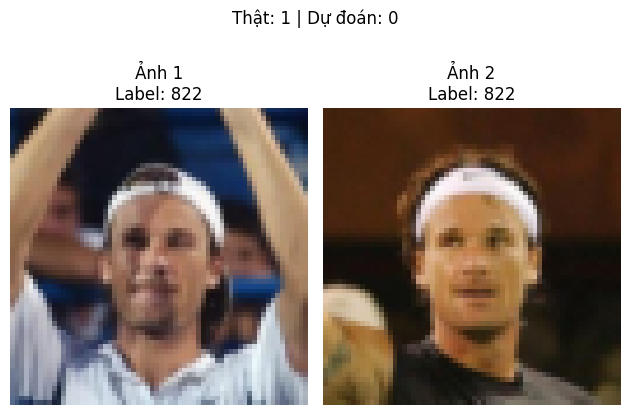

In [39]:
from torch.nn import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

correct = 0
total = 0
threshold = 0.2

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for i, (x1, x2, y_true, label1, label2, *rest) in enumerate(test_loader):
        x1, x2 = x1.to(device), x2.to(device)
        y_true = y_true.view(-1).to(device)

        # Forward
        out1, out2 = model(x1, x2)
        dist = F.pairwise_distance(out1, out2)

        # Dự đoán: nếu khoảng cách nhỏ hơn ngưỡng → cùng người
        y_pred = (dist < threshold).float().view(-1)

        # Tính số lượng đúng
        correct += (y_pred == y_true).sum().item()
        total += y_true.size(0)

        # Lưu để tính metric sau này
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y_true.cpu().numpy())

        # In thông tin debug cho batch đầu tiên
        if i == 0:
            print(f"\n📦 Batch {i+1}")
            print("✅ Nhãn thực tế:", y_true.tolist())
            print("🔍 Dự đoán      :", y_pred.tolist())
            print("🧬 Label ảnh 1  :", label1)
            print("🧬 Label ảnh 2  :", label2)

            for j in range(len(x1)):
                print(f"\n🔢 Cặp ảnh {j+1} - Khoảng cách: {dist[j].item():.4f}")
                show_images(
                    x1[j], x2[j],
                    label1[j], label2[j],
                    y_true[j], y_pred[j]
                )

# 🎯 Accuracy
accuracy = correct / total

# 🧮 Các metric khác
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)




🎯 Accuracy      : 71.65%
📌 Precision     : 66.76%
📌 Recall        : 86.24%
📌 F1-score      : 75.26%


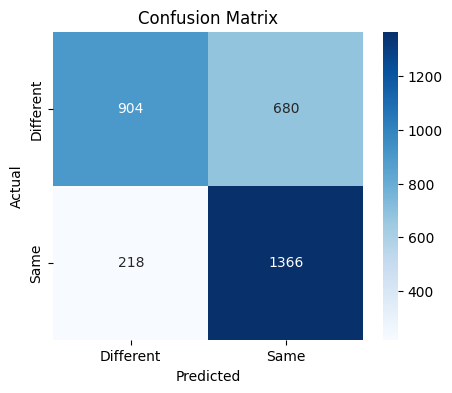

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"\n🎯 Accuracy      : {accuracy * 100:.2f}%")
print(f"📌 Precision     : {precision * 100:.2f}%")
print(f"📌 Recall        : {recall * 100:.2f}%")
print(f"📌 F1-score      : {f1 * 100:.2f}%")
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Different", "Same"], yticklabels=["Different", "Same"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# V. Lưu model 

In [28]:
!pip install huggingface_hub


In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret(" HUGGINGFACE_TOKEN")
login(secret_value_0)



In [5]:
from huggingface_hub import HfApi

api = HfApi()

repo_name = "siamese-face-model-v4_new"   # 👉 Đổi tên nếu muốn
username = api.whoami()["name"]       # Lấy username hiện tại

full_repo_name = f"{username}/{repo_name}"
api.create_repo(repo_id=full_repo_name, private=False)  # Để private=True nếu muốn ẩn


RepoUrl('https://huggingface.co/Nguyenhhh/siamese-face-model-v3_new', endpoint='https://huggingface.co', repo_type='model', repo_id='Nguyenhhh/siamese-face-model-v3_new')

In [31]:
from huggingface_hub import Repository

repo_local_dir = repo_name
repo_url = f"https://huggingface.co/{full_repo_name}"
repo = Repository(local_dir=repo_local_dir, clone_from=repo_url)

# Cấu hình Git nếu chưa cấu hình
!git config --global user.email "your@email.com"
!git config --global user.name "Your Name"


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Nguyenhhh/siamese-face-model-v1_new into local empty directory.


In [32]:
import torch
import json

# Giả sử bạn có biến `model` là mô hình đã huấn luyện
model_path = f"{repo_local_dir}/pytorch_model.bin"
torch.save(model.state_dict(), model_path)

# Tạo thêm file config.json (tuỳ chọn)
config = {"model_type": "siamese-net", "input_size": 64}
with open(f"{repo_local_dir}/config.json", "w") as f:
    json.dump(config, f)

# Upload lên Hugging Face
repo.push_to_hub(commit_message="🚀 Upload Siamese Face Model V2")


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

To https://huggingface.co/Nguyenhhh/siamese-face-model-v1_new
   165f26e..0c17856  main -> main



'https://huggingface.co/Nguyenhhh/siamese-face-model-v1_new/commit/0c17856918317a2a6bd0ab81ef4710949e9b6119'

# V.I Load Model (Đã có sẵn)

In [6]:
from huggingface_hub import hf_hub_download
import torch
import json

# Repo ID bạn đã upload
repo_id = "Nguyenhhh/siamese-face-model-v1_new"  # 👈 Thay bằng repo của bạn

# Tải file model và config
model_path = hf_hub_download(repo_id=repo_id, filename="pytorch_model.bin")
config_path = hf_hub_download(repo_id=repo_id, filename="config.json")

# Đọc config nếu có
with open(config_path, "r") as f:
    config = json.load(f)


pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QuickGELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model=768, n_head=8):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_head, batch_first=True)
        self.ln_2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 3072),
            QuickGELU(),
            nn.Linear(3072, d_model)
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x), self.ln_1(x), self.ln_1(x))[0]
        x = x + self.mlp(self.ln_2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, image_size=64, patch_size=16, d_model=768, depth=12, n_head=8):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d_model, kernel_size=patch_size, stride=patch_size, bias=False)
        num_patches = (image_size // patch_size) ** 2

        # Thêm cls token và vị trí embedding
        self.class_embedding = nn.Parameter(torch.randn(1, 1, d_model))
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))

        self.ln_pre = nn.LayerNorm(d_model)
        self.transformer = nn.Sequential(*[
            ResidualAttentionBlock(d_model, n_head) for _ in range(depth)
        ])
        self.ln_post = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.conv1(x)  # [B, C, H, W] -> [B, d_model, h, w]
        x = x.flatten(2).transpose(1, 2)  # [B, d_model, N] -> [B, N, d_model]

        cls_token = self.class_embedding.expand(x.size(0), -1, -1)  # [B, 1, d_model]
        x = torch.cat([cls_token, x], dim=1)  # [B, N+1, d_model]

        x = x + self.positional_embedding[:, :x.size(1), :]
        x = self.ln_pre(x)
        x = self.transformer(x)
        return self.ln_post(x[:, 0])  # Trả về embedding của [CLS] token


class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = VisionTransformer()

    def forward(self, x):
        return self.vit(x)


class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        return self.embedding_net(x1), self.embedding_net(x2)




In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


SiameseNet(
  (embedding_net): EmbeddingNet(
    (vit): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Sequential(
        (0): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): QuickGELU()
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
        (1): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQ

## VI. Check

In [42]:
from torch.nn import functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

correct = 0
total = 0
threshold = 0.2  # 👈 Tùy chỉnh ngưỡng nếu cần

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for i, (x1, x2, y_true, label1, label2, *rest) in enumerate(test_loader):
        x1, x2 = x1.to(device), x2.to(device)
        y_true = y_true.view(-1).to(device)

        # Forward
        out1, out2 = model(x1, x2)
        dist = F.pairwise_distance(out1, out2)

        # Dự đoán: nếu khoảng cách nhỏ hơn ngưỡng → cùng người
        y_pred = (dist < threshold).float().view(-1)

        # Tính số lượng đúng
        correct += (y_pred == y_true).sum().item()
        total += y_true.size(0)

        # Lưu để tính metric sau này
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y_true.cpu().numpy())

        


accuracy = correct / total
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n🎯 Accuracy      : {accuracy * 100:.2f}%")
print(f"📌 Precision     : {precision * 100:.2f}%")
print(f"📌 Recall        : {recall * 100:.2f}%")
print(f"📌 F1-score      : {f1 * 100:.2f}%")


🎯 Accuracy      : 70.14%
📌 Precision     : 78.74%
📌 Recall        : 55.18%
📌 F1-score      : 64.88%
